In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output
import joblib
import numpy as np
import os
import pandas as pd

from TSEnsemble import TSEnsemble

SEED = 42
np.random.seed(SEED)

2024-05-20 13:41:10.729707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set currency
currency = 'cop'

# Set params
base_params = {
    'sl': [60, 70, 80],
    'hl': [2, 3],
    'lr': [.01]
}
meta_params = {
    'rf': {
        'n_estimators': 100
    },
    'ridge': {
        'alpha': 1.
    },
    'xgb': {
        'n_estimators': 1000,
        'max_depth': 8,
        'learning_rate': .01
    }
}
diff = 1
bags = 3
epochs = 30
hold_split = .3
test_split = .3
verbose = 2

# Set series range
dt_from = '2012-01-01'
dt_to = '2018-11-27'

In [3]:
df = pd.read_csv(f'{os.getcwd()}/docs/sample-fx.csv', sep=',')

# Parse currency and set time series
y = df[df['currency'] == currency.upper()].drop(['currency'], axis=1).fillna(0).set_index('rated_at').rename_axis(None)
y.index = pd.to_datetime(y.index)
y = y['value'].sort_index()[dt_from:dt_to]

print(f'Total: {len(y)}')
y.tail(10)

Total: 2523


2018-11-18    3614.20
2018-11-19    3609.33
2018-11-20    3617.02
2018-11-21    3635.09
2018-11-22    3638.51
2018-11-23    3645.48
2018-11-24    3660.79
2018-11-25    3619.16
2018-11-26    3623.43
2018-11-27    3672.91
Name: value, dtype: float64

Networks: 6 | Forecast: 60 | Maxlen: 140
Train: 1765 | Meta: 530 | Test: 227


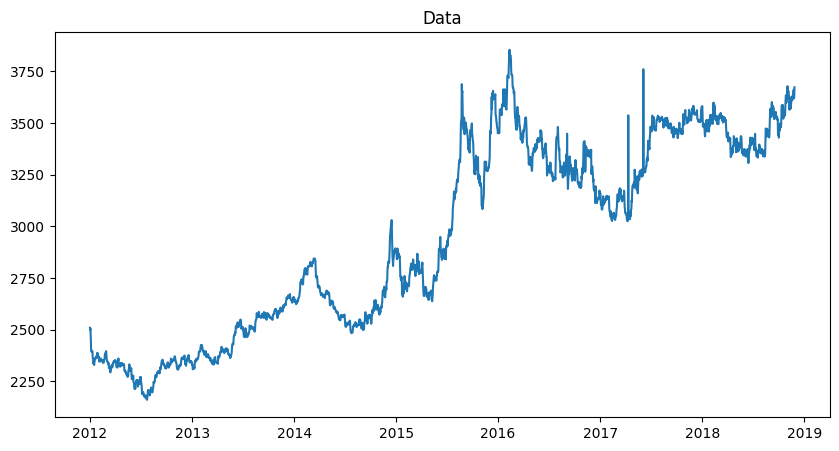

In [4]:
# Initialize model
model = TSEnsemble(bags=bags, diff=diff, epochs=epochs, seed=SEED, verbose=verbose)

networks, num_fc, max_sl = model.set_params(base_params, meta_params)
dtrain, dmeta, dtest = model.init_series(y, hold_split=hold_split, test_split=test_split)

print(f'Networks: {networks} | Forecast: {num_fc} | Maxlen: {max_sl}')
print(f'Train: {len(dtrain)} | Meta: {len(dmeta)} | Test: {len(dtest)}')
model.plot_data(y, file='data.png')

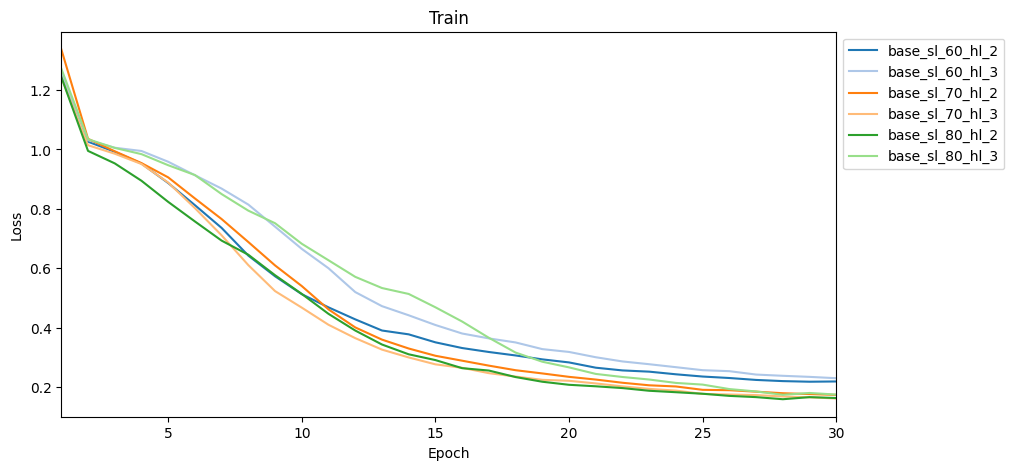

In [5]:
# Train model
model.model_train()

clear_output(wait=True)
model.plot_train(file='losses.png')

Mean Pearson Corr: 13.85%
Best Model: meta_ridge (82.96 | 1.97%)


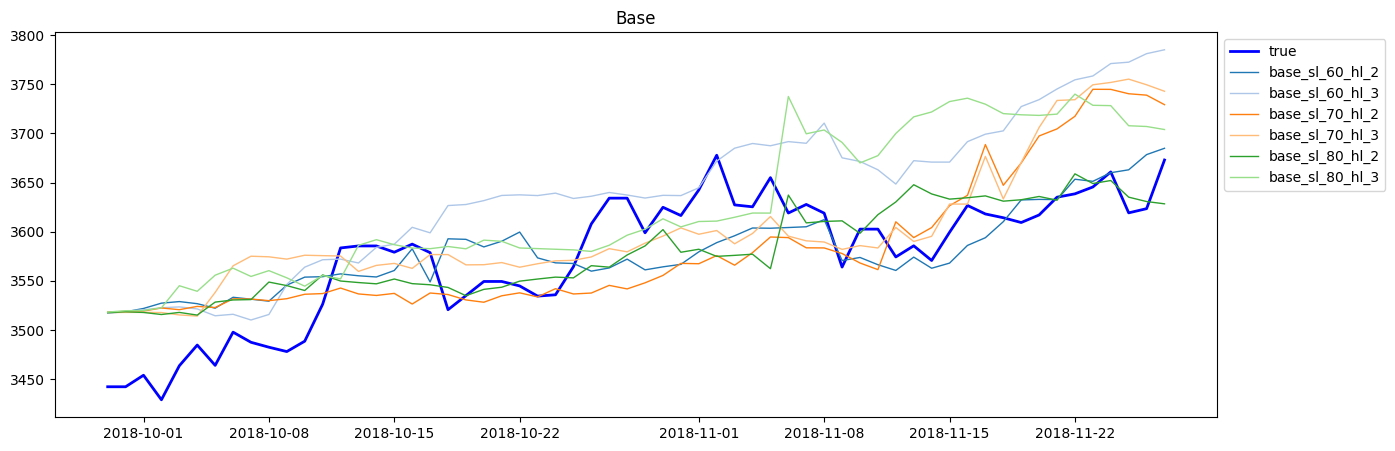

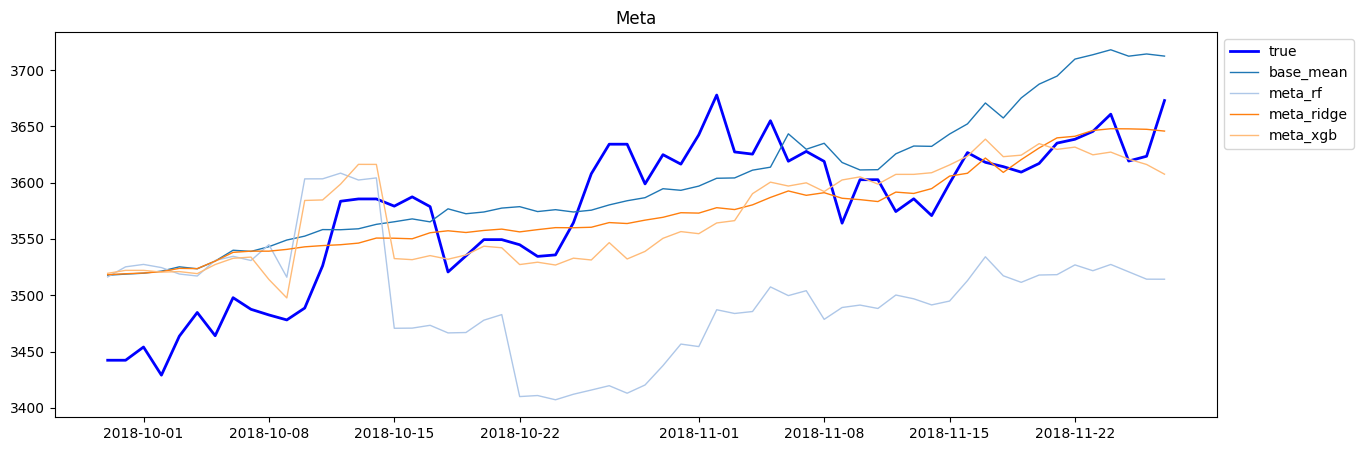

In [6]:
# Test model
model.model_test()

best, scores = model.best_model()
models = model.get_models()
corr = model.get_mean_corr()

clear_output(wait=True)
print('Mean Pearson Corr: {:0.2f}%'.format(corr * 100))
print('Best Model: {} ({:0.2f} | {:0.2f}%)'.format(best, scores['rmse'], scores['mape']))
model.plot_forecast(title='Base', keys=models[:networks], file='base_test.png')
model.plot_forecast(title='Meta', keys=models[networks:], file='meta_test.png')

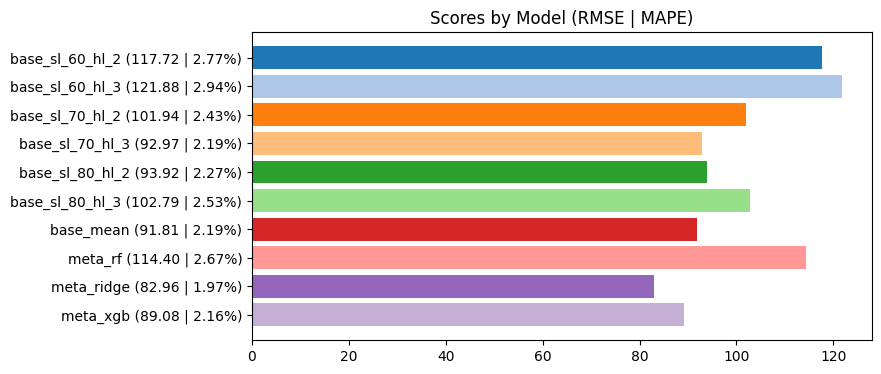

In [7]:
model.plot_test(score='rmse', file='scores.png')

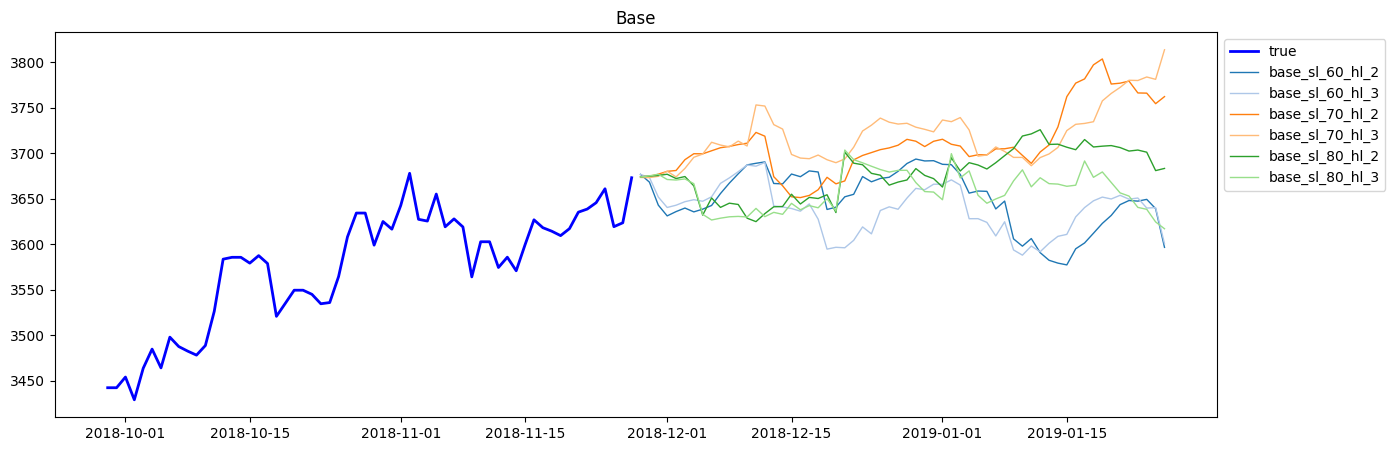

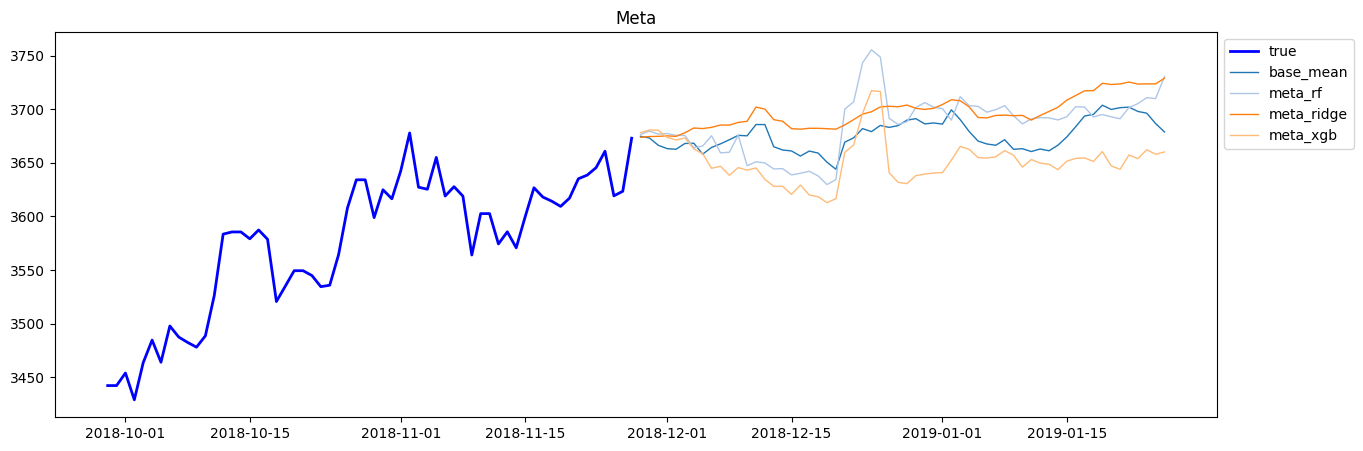

In [8]:
# Forecast model
model.model_forecast()

clear_output(wait=True)
model.plot_forecast(title='Base', keys=models[:networks], forecast=True, file='base_forecast.png')
model.plot_forecast(title='Meta', keys=models[networks:], forecast=True, file='meta_forecast.png')

In [9]:
# Save model
joblib.dump(model, f'{os.getcwd()}/files/ensemble.pml')

['/Users/LuisS/HD/Proyectos/Code/ts-forecast-deep-ensemble/files/ensemble.pml']